<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Causal-Forest-Estimation-of-Heterogenous-Treatment-Effects:-An-Application-to-a-Corruption-Audit-Experiment" data-toc-modified-id="Causal-Forest-Estimation-of-Heterogenous-Treatment-Effects:-An-Application-to-a-Corruption-Audit-Experiment-1">Causal Forest Estimation of Heterogenous Treatment Effects: An Application to a Corruption Audit Experiment</a></span><ul class="toc-item"><li><span><a href="#1.-Introduction" data-toc-modified-id="1.-Introduction-1.1">1. Introduction</a></span></li><li><span><a href="#2.-Causal-Forests:-Theoretical-Background" data-toc-modified-id="2.-Causal-Forests:-Theoretical-Background-1.2">2. Causal Forests: Theoretical Background</a></span><ul class="toc-item"><li><span><a href="#2.1-The-Potential-Outcomes-Model" data-toc-modified-id="2.1-The-Potential-Outcomes-Model-1.2.1">2.1 The Potential Outcomes Model</a></span></li><li><span><a href="#2.2-Honest-and-Adaptive-Causal-Trees" data-toc-modified-id="2.2-Honest-and-Adaptive-Causal-Trees-1.2.2">2.2 Honest and Adaptive Causal Trees</a></span></li></ul></li><li><span><a href="#3.-Brief-Description-of-Olken-(2007)" data-toc-modified-id="3.-Brief-Description-of-Olken-(2007)-1.3">3. Brief Description of Olken (2007)</a></span></li><li><span><a href="#4.-Simulation-Study" data-toc-modified-id="4.-Simulation-Study-1.4">4. Simulation Study</a></span><ul class="toc-item"><li><span><a href="#4.1-The-Data-Generating-Process" data-toc-modified-id="4.1-The-Data-Generating-Process-1.4.1">4.1 The Data Generating Process</a></span></li><li><span><a href="#4.2-Results" data-toc-modified-id="4.2-Results-1.4.2">4.2 Results</a></span></li></ul></li><li><span><a href="#5.-Empirical-Application" data-toc-modified-id="5.-Empirical-Application-1.5">5. Empirical Application</a></span></li><li><span><a href="#References" data-toc-modified-id="References-1.6">References</a></span></li></ul></li></ul></div>

# Causal Forest Estimation of Heterogenous Treatment Effects: An Application to a Corruption Audit Experiment

In [1]:
install.packages("grf")
install.packages("gridExtra")
install.packages("DiagrammeR")
install.packages("ggstance")
install.packages("itertools")
install.packages("truncnorm")
install.packages("ggplot2")
install.packages("tmvtnorm")
install.packages("MASS")
install.packages("lmtest")
install.packages("cowplot")
install.packages("plyr")
install.packages('latex2exp')
install.packages("gridExtra")

library(grf)
library(gridExtra)
library(DiagrammeR)
library(ggstance)
library(itertools)
library(truncnorm)
library(tmvtnorm)
library(ggplot2)
library(foreign)
library(MASS)
library(lmtest)
library(cowplot)
library(plyr)
library(latex2exp)
library(gridExtra)

Warning message in install.packages("grf"):
“installation of package ‘grf’ had non-zero exit status”Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Libra

In [2]:
source("functions.R")

In [3]:
set.seed(1)

## 1. Introduction

This notebook assesses the use of causal forests for heterogenous treatment effect estimation and inference in a simulation study that is designed on the basis of a corruption audit experiment in Indonesia conducted by Olken (2007). It further applies different versions of causal forests to estimate average and conditional average treatment effects using the empirical data from the experiment.

Causal forests are a method for nonparametric estimation of treatment effects that builds on the random forest algorithm developed by Breiman (2001). The causal forest algorithm has been developed and theoretically analyzed in seminal contributions by  Athey and Imbens (2016) and Wager and Athey (2018), and has been integrated into a more general theory of generalized random forests (Athey, Tibshirani and Wager 2019) whose algorithm is implemented in R package grf. This algorithm can be used to flexibly estimate a treatment effects conditional on covariates without knowing which covariates might be moderators of the treatment effect.

The simulation study in this project is modelled on the empirical set-up from a randomized experiment conducted by Olken (2007) that assesses the effect of audit on corruption in Indonesian villages. A key feature of this experiment is that randomization of treatment is administered at the level of subdistricts, which contain multiple villages, such that all villages from a given subdistrict either receive treatment or do not. Clustering poses an additional challenge for the causal forest algorithm because units of observation within a cluster might not be independently distributed, and thus requires an adaption of the algorithm to this experimental design. For one thing, I will investigate the relative performance of cluster-robust and non-cluster-robust forests for predicting treatment effect heterogeneity. Further, the simulation study tests the performance of honest causal forests, which use independent samples for placing splits and leaf estimation thus reducing bias at the cost of a smaller sample size, against the adaptive causal forest, which uses the same sample for placing splits and leaf estimation. All these approaches will be compared to least-squares estimation of treatment interactions in a linear regression model. This will underline the advantage of nonparametric methods for conditional treatment effect estimation when the true model is not precisely known, and on the other hand stress the strength of conventional methods when the estimated model can be correctly specified. Further, the simulation study assesses coverage probabilities of causal forests at varying levels of model complexity. The insights from the simulation study are subsequently used to analyze the empirical data from the randomized experiment using causal forests.  

This notebook proceeds as follows: Section 2 presents some theoretical background on causal forest that is used to formulate research questions which are assessed in the simulation study in section 3. Drawing on the insights from the simulation study, section 4 applies various versions of causal forests to the empirical data from the experiment. Section 5 concludes.  

## 2. Causal Forests: Theoretical Background

The explanation of the theoretical background for causal forests draws on the representation in Athey and Imbens (2016), Wager and Athey (2018) and Athey and Wager (2019). Athey, Tibshirani and Wager (2019) develop an algorithm for growing generalized random forests, which include causal forests as a special case. The algorithm is implemented in the R package grf, which includes the causal_forests function that is used in this project. The causal forest algorithm Athey, Tibshirani and Wager (2019) propose differs slightly from the algorithms in Athey and Imbens (2016) and Wager and Athey (2018). In particular, Athey, Tibshirani and Wager (2019) use an approximate criterion based on gradient-based approximations to nonlinear equations they are trying to solve to obtain estimates for the parameter of interest for tree-splitting, which results in greater computational efficiency. Athey, Tibshirani and Wager (2019) note that a special case of their (non-approximated) criterion function underlies the splitting rule in Athey and Imbens (2016) and provide a detailed proof of this proposition. Athey and Imbens (2016) develop their theory for causal forests specifically tailored to treatment effect estimation in the potential outcomes framework. This representation allows to much more clearly develop hypotheses for the simulation study from the theoretical background than the more general representation in Athey, Tibshirani and Wager (2019). Athey and Imbens (2016) is also the main source Prof Janys used in the lecture to explain causal forests.

### 2.1 The Potential Outcomes Model

Assume we have $n$ units indexed by $i=1,...,n$. Let $W_i \in \{0,1\}$ be the treatment indicator, where $W_i=1$ if unit $i$ is assigned treatment and $W_i=0$ if unit $i$ is part of the control group. Let $X_i \in \mathbb{R}^k$ be a vector of covariates not affected by treatment. Causal effects are formulated in the potential outcomes framework, where for each unit $i$ one considers potential outcomes $Y_i(0)$ and $Y_i(1)$ if the observation had been in the control or treatment group, respectively. Define the average treatment effect as $\tau={\mathbb{E}[Y_i(1)-Y_i(0)]}$ and the conditional average treatment effect as $\tau(x)={\mathbb{E}[Y_i(1)-Y_i(0)|X_i=x]}$ (Athey and Wager 2019). The main objective of causal forests is to estimate the function $\tau(x)$. Note that one can ever only observe either $Y_i(0)$ or $Y_i(1)$ and the forest can thus not be directly trained on unit-level differences $Y_i(1)-Y_i(0)$, which constitutes the main challenge for the causal forest algorithm (Wager and Athey 2018).

One posits the assumption of unconfoundedness, i. e. that treatment assignment is independent of the potential outcomes conditional on covariates (Athey and Wager 2018):
\begin{equation}
(Y_i(0), Y_i(1))\perp \!\!\! \perp  W_i|X_i.
\tag{1}
\end{equation}

In a randomized experiment as in the paper by Olken (2007), which serves as the benchmark for this project, the assumption of unconfoundedness holds even without conditioning on covariates as the propensity score $e(x)=Pr(W_i=1|X_i=x)$ can be written as $e(x)=p$ in this case, i. e. the treatment assignment probability does not depend on covariates and is thus constant for all units. Since this project focuses on estimation and inference of treatment effects in a randomized study, I will proceed with the outline of the theoretical background positing the stronger assumption of complete randomization $(Y_i(0), Y_i(1), X_i)\perp \!\!\! \perp  W_i$ following the representation in (Athey and Imbens 2016).


### 2.2 Honest and Adaptive Causal Trees

I proceed by introducing some of the vocabulary required for the further analysis using the representation in Athey and Imbens (2016). A tree $\Pi$ is a partitioning of the covariate space $\mathbb{X}$, where $\#(\Pi)$ denotes the elements of the partition. The tree can be written as the set of leaves whose union covers the covariate space, i. e. $\Pi=\{\ell_1, ..., \ell_{\#(\Pi)}\}$ with $\cup_{j=1}^{\#(\Pi)}\ell_{j}=\mathbb{X}$. Let $\mathbb{S}$ be the space of samples.

For a sample $\mathcal{S}\in\mathbb{S}$ let $\mathcal{S}_{treat}$ be the sample of treated units and $\mathcal{S}_{control}$ be the sample of control units with $N_{treat}$ and $N_{control}$ denoting the number of treatment and control units respectively. For each unit $i$ the researcher can observe the response $Y_i^{obs}$, $W_i$ and $X_i$. For a given tree $\Pi$, realization of the covariate vector $x$ and treatment level $w$, define the average outcome by
\begin{equation}
\mu(w,x;\Pi)=\mathbb{E}[Y_i(w)|X_i\in \ell(x;\Pi)]
\tag{2}
\end{equation}
and accordingly the average causal effect by
\begin{equation}
\tau(x;\Pi)=\mathbb{E}[Y_i(1)-Y_i(0)|X_i\in \ell(x;\Pi)]=\mu(1,x;\Pi)-\mu(0,x;\Pi).
\tag{3}
\end{equation}
These can be estimated by 
\begin{equation}
\hat{\mu}(w,x;\mathcal{S},\Pi)=\frac{1}{\#(\{i\in\mathcal{S}_w:X_i\in\ell(x;\Pi)\})}\sum_{i\in\mathcal{S}_w:X_i\in\ell(x;\Pi)}Y_i^{obs} \,\,\text{and}
\tag{4}
\end{equation}
\begin{equation}
\hat{\tau}(x;\Pi)=\hat{\mu}(1,x;\mathcal{S},\Pi)-\hat{\mu}(0,x;\mathcal{S},\Pi).
\tag{5}
\end{equation}

Athey and Imbens (2016) consider two different approaches for estimating treatment effects using causal trees: the adaptive approach and the honest approach. The honest approach uses an estimation sample $\mathcal{S}^{est}$ for leaf estimation that is independent of the training sample $\mathcal{S}^{tr}$ which was used to build the tree. The adaptive approach, on the other hand, uses a single (training) sample $\mathcal{S}^{tr}$ both for tree building and leaf estimation. These differences already hint at potential strengths and weaknesses of the respective approaches: since the honest approach splits the sample, there are less observations in both subsamples which might lead to inaccurate estimation of treatment effects. The adaptive approach is at risk of yielding too extreme estimates for the treatment effects because the splits might be based on observations that yield potentially spurious extreme treatment effects and these observations are then also used for leaf estimation rather than an independent estimation sample (Athey and Imbens 2016). This trade-off between the reduction in bias an sample size will be discussed in detail in the simulation study.

For the honest approach, the authors introduce an adjusted mean squared error for the treatment effect as the objective function: 

\begin{equation}
MSE_{\tau}(\mathcal{S}^{te}, \mathcal{S}^{est}, \Pi)=\frac{1}{N{te}}\sum_{i\in\mathcal{S}^{te}}\big\{\tau_i-\hat{\tau}(X_i; \mathcal{S}^{est}, \Pi))^2-\tau_i^2\big\},
\tag{6}
\end{equation}

where $\mathcal{S}^{te}$ is an independent test sample and one shall note that substracting $\tau_i^2$ does not affect how different estimators are ranked

The $EMSE(\Pi)$ is the expectation of the adjusted mean squared error over the estimation and test sample:

\begin{equation}
EMSE(\Pi)=\mathbb{E}_{\mathcal{S}^{est}, \mathcal{S}^{te}}[MSE_{\tau}(S^{te}, S^{est}, \Pi)].
\tag{7}
\end{equation}

In the adaptive case, there is no independent estimation sample and the adjusted mean squared error therefore can be written as

\begin{equation}
MSE_{\tau}(S^{te}, S^{tr}, \Pi)=\frac{1}{N^{te}}\sum_{i\in\mathcal{S}^{te}}\big\{\tau_i-\hat{\tau}(X_i; \mathcal{S}^{tr}, \Pi))^2-\tau_i^2\big\}.
\tag{8}
\end{equation} Noting that

\begin{equation}
\mathbb{E}_{\mathcal{S}^{te}}[\tau_i|i\in\mathcal{S}^{te}:i\in\ell(x,\Pi)]=\mathbb{E}_{\mathcal{S}^{te}}[\hat{\tau}(x;\mathcal{S}^{te}, \Pi)]
\tag{9}
\end{equation}

and restricting only to the training sample for placing splits one obtains

\begin{equation}
-\widehat{MSE}_{\tau}(S^{tr}, S^{tr}, \Pi)=\frac{1}{N^{tr}}\sum_{i\in\mathcal{S}^{tr}}\hat{\tau}^2(X_i; \mathcal{S}^{tr}, \Pi)
\tag{11}
\end{equation}

as an in-sample estimator for the infeasible adjusted mean squared error.

For the honest approach, one in a first step expand the MSE by 

\begin{equation}
MSE_{\tau}(S^{te}, S^{est}, \Pi)=\frac{1}{N^{te})}\sum_{i\in\mathcal{S}^{te}}\big\{[\tau_i-\tau(X_i; \Pi)+\tau(X_i; \Pi)-\hat{\tau}(X_i; \mathcal{S}^{est}, \Pi)]^2-\tau_i^2\big\}.
\tag{12}
\end{equation}

Applying expectation operators and noting that $\mathbb{E}_{\mathcal{S}^{est}}[\hat{\tau}(X_i; S^{est},\Pi)]=\tau(X_i; \Pi)$, one obtains the expectation of the (negative) adjusted mean squared error over estimation and test samples as

\begin{equation}
-EMSE_{\tau}(\Pi)=\mathbb{E}_{X_i}[\tau^2(X_i; \Pi)]-\mathbb{E}_{X_i, \mathcal{S}_{est}}[\mathbb{V}(\hat{\tau}(X_i; \mathcal{S}^{est}, \Pi)].
\tag{13}
\end{equation}

Assuming approximately equal leaf size, one can estimate the first component in (13) by

\begin{equation}
\hat{\mathbb{E}}(\tau^2(x; \Pi))=\hat{\tau}^2(x; \mathcal{S}^{est}, \Pi)-\frac{1}{N^{tr}}\sum_{\ell \in \Pi}\big(\frac{S_{\mathcal{S}^{tr}_{treat}}^2}{p}+\frac{S_{\mathcal{S}^{tr}_{control}}^2}{1-p}\big), 
\tag{14}
\end{equation}

where the second term in (14) is introduced to account for the variance of $S_{\mathcal{S}^{tr}_{control}}^2$ and $S_{\mathcal{S}^{tr}_{treated}}^2$ are estimates of the within-leaf variances of $Y_i$ of the treatment and control group respectively and $p$ is the share of treated units. 

Again, assuming approximately equal leaf size the second term in (13) can be estimated by 

\begin{equation}
\hat{\mathbb{E}}(\mathbb{V}(\hat{\tau}(X_i; \mathcal{S}^{est}, \Pi))=\frac{1}{N^{est}}\sum_{\ell \in \Pi}\big(\frac{S_{\mathcal{S}^{tr}_{treat}}^2}{p}+\frac{S_{\mathcal{S}^{tr}_{control}}^2}{1-p}\big). 
\tag{15}
\end{equation}

The estimators in (14) and (15) summed up  yield the in-sample estimator $-\widehat{EMSE}_{\tau}(\Pi)$ for expected infeasible (negative) mean squared error.

Both the adaptive and the honest approach thus reward heterogeneity in conditional treatment effect estimates. The honest approach further penalizes variance within leaves. Equations (14) and (15) help to understand splits how splits are made in the honest causal trees. I here draw on material provided in the online appendix to Davis and Heller (2017). The splitting algorithm for the adaptive case is straightforward because it simply does not include the within-leaf variance penalty. 

One calculates the value of the objective function $O$ derived from (16) for the unpartitioned data: 

\begin{equation}
O=(N^{tr}_{treat;\ell}+N^{tr}_{control;\ell})*\hat{\tau}^2(X_i; \mathcal{S}^{tr}, \Pi)-2*\big(\frac{S_{\mathcal{S}^{tr}_{treat};\ell}^2}{N^{tr}_{treat;\ell}}+\frac{S_{\mathcal{S}^{tr}_{control};\ell}^2}{N^{tr}_{control;\ell}}\big).
\tag{17}
\end{equation}

The split that maximizes the sum of the objective function in the child leaves (if there exists such a split) is implemented subject to a constraint on the minimum number of observations in the leaf.

This concludes the explanation for a single causal tree. A causal forest grows B such trees drawing a new random subsample every time. The forest averages tree-specific treatment effects $\hat{\tau}_b(x)$ for $b\in\{1, ..., B\}$ to predict $\hat{\tau}_b(x)=\sum_{b=1}^B\hat{\tau}_b(x)$.

**Asymptotic Normality**

Imposing the assumption of Lipschitz continuity of the estimated conditional mean functions, treatment propensities that are bounded away from zero and one, and a subsample size in each tree that scales below the size of the total sample,  Wager and Athey (2018) prove asymptotic Gaussianity of the conditional treatment effect prediction of the honest forest. Athey, Tibshirani and Wager (2019) use the results from Wager and Athey (2018) to establish Gaussianity in their setting.

**Cluster-Robustness**

When the observations can be assigned to clusters, there is a cluster-robust version of the honest causal forest in order to account for cluster-specific idiosyncratic moderators of the treatment effect. This causal forest draws a subsample of clusters from the set of clusters $\mathcal{C}_{b, tr}\subset\{1,...,C\}$ for placing splits and only considers observations to be out-of-bag in the estimation step if $C_i\nsubseteq{\mathcal{C}}_{b, tr}$ (Athey and Wager 2019). The causal_forest function allows to specify the number of observations drawn from each cluster. I set equalize_cluster_weights=True so that the number of observations drawn from each sample is equal to the number of observations from the cluster with the smallest number of observations. 

## 3. Brief Description of Olken (2007)

Olken (2007) investigates the effect of top-down monitoring on corruption in village projects using data from a randomized controlled trial he conducted in around 600 Indonesian villages. By the time the experiment was launched, each village had received funds for road projects through a nationwide infrastructure program but had not yet started the construction. Randomly chosen villages were informed that their road project would be monitored by the central government audit agency, which meant an increase in the probability of external government audit from approximately 4 percent to 100 percent for these villages. Audits can lead to prosecution of village officials in the case of malfeasance. Randomization was clustered at the subdistrict level. Audits were stratified by district and time the subdistrict had participated in the infrastructure program. The probability that a village receives the audit treatment is independent of all village or stratum characteristics, however, such that consistent estimation of the average treatment effect is possible even without including stratum fixed effects (Olken 2007). Since the author does not provide data on the time the subdistrict has participated in the infrastructure program and the probability that a subdistrict receives treatment is constant, I will not introduce a stratum variable in the simulation study. Two further treatments that meant to increase grassroots participation were administered, but these were independent of the audit treatment. After consulting with Prof Janys, I will disregard these further treatments in the simulation study in order to keep the data generating processes more tractable. Olken (2007)  uses the discrepancy between costs reported by the village and the estimate of an independent team of engineers as a measure of corruption.

## 4. Simulation Study

This subsection contains my simulation study, first describing the data generating process and subsequently presenting main results.

In [4]:
randomization_data <- read.dta("/Users/gerwinkiessling/Desktop/jpepublic/jperandomizationdata.dta")
road_data <- read.dta("/Users/gerwinkiessling/Desktop/jpepublic/jperoaddata.dta")

### 4.1 The Data Generating Process

The following variables were used in the simulation study:

* ln_diff_items: Dependent variable, i.e. major items in roads and ancilliary projects 
* audit: Audit treatment, i.e. increasing probability of external government audit from 4 to 100 percent

* population: Village Population (in 1,000)
* mosques: Mosques per 1,000 population
* totalallocation: Total budget (in rp. million)
* subprojects: Number of subprojects
* percentage_poor: Percentage of household that are poor
* distance: Distance to subdistrict
* head_education_years: Village head years of education
* head_salary: Village head salary (hectares)
* head_age: Village head age
* mountainous: Mountainous dummy.

**Covariates**

For the continuous control variables, i.e. the control variables excluding the mountainous dummy, I in a first step calculate means, and a covariance matrix from the empirical data. I evaluated  histograms for the respective variables, which reveal that the distibution of most variables is well approximated by a truncated normal distribution. I thus chose to simulate data for all continuous variables by drawing from a truncated multivariate normal distribution using the estimated mean vector and covariance matrix as inputs. I specify 0 as the lower bound for all variables and introduce an upper bound of 1 for the percentage_poor variable, while specifying no upper bound for the remaining variables. I proceed by estimating a logit model using the empirical data with the mountainous dummy as the dependent variable and the continuous covariates as the explanatory variables, and use the estimated coefficients to calculate the probability that a village is mountainous based on the simulated data for the continuous covariates. I use this probability to draw randomly from a binomial distribution, where the outcome determines whether a village is mountainous or not in the simulated data.

**Clustering and Randomization**

As treatment is perfectly correlated within a subdistrict, I proceed by generating clusters. To this end, population size, number of mosques, total budget, the percentage of poor households and the mountainous dummy are defined as similarity variables imposing the assumption that villages from the same subdistrict should be somewhat similar along these dimensions. I scale each similarity variable by subtracting the mean from the respective village observation and dividing by the standard deviation in order to make the similarity variables comparable. Then a similarity score is obtained by summing up the realizations of the scaled similarity variables and an error term with a large variance $\eta_i\sim\mathcal{N}(0, 9)$ in order to introduce some randomness in the process of clustering. I then order the village observations by the similarity score. There are around 150 subdistricts with differing numbers of villages per cluster in the empirical dataset, yielding an average of around 4 villages. Mimicking the feature of unevenly sized clusters from the empirical dataset, I generate heterogeneity in cluster sizes introducing three different cluster sizes. For the baseline case of 600 villages and 150 subdistricts, for instance, there are clusters of sizes 3, 4 and 5. For the case of 6000 villages and 150 subdistricts, there are clusters of sizes 30, 40 and 50. A 48 percent chance of treatment for each subdistrict as in the original article (Olken 2007) is subsequently implemented.

**Three Models of Varying Complexity**

The outcome variable log of difference in major items is generated using three different models of varying complexity. These were specified after performing least-squares estimation on the empirical data of different regression models including interactions of covariates with the audit treatment. Covariates and interactions for which coefficient estimates revealed higher levels of statistical significance were included in the simulation models and the corresponding coefficient estimates were chosen to be of similar magnitude as the estimates on the empirical data.

* The Simple Model

\begin{equation}
\ln diff\_items_{ij}=0.22-0.07*audit_j+0.0001*totalallocation_{ij}+0.017*head\_salary_{ij}+0.016*audit_j*head\_ +\epsilon_{ij}
\tag{19}
\end{equation}

* The Medium Complexity Model

\begin{equation}
\ln diff\_items_{ij}= 0.27  -0.11*audit_j  +0.0001*totalallocation_{ij}  -0.016head\_education\_years_{ij}  +0.007*head\_salary_{ij} -0.0002*head\_salary_{ij}^2 +0.00003*head\_salary_{ij}*totalallocation{ij} -0.001*audit_{j}*head\_ totalallocation_{ij} +0.01audit_{j}*head\_ salary_{ij} +0.0002*audit_{j}*head\_ salary_{ij}^2 +0.00002*audit_{j}*head\_ salary_{ij}*totalallocation_{ij}+\epsilon_{ij}
\tag{20}
\end{equation}

* The Complex Model

\begin{equation}
\ln diff\_items_{ij}=0.5 -
    0.05*audit_{ij}-
    0.003*head\_age_{ij}
    0.01*percentage\_poor_{ij}-
    0.001*population_{ij}-
    0.01*mosques_{ij}-
    0.0005*totalallocation_{ij}+
    0.005*head\_salary_{ij}-
    0.001*distance_{ij}-
    0.002*subprojects_{ij}-
    0.2*audit_j*percentage\_poor_{ij}-
    0.02*audit_j*population_{ij}-
    0.004*audit_j*mosques_{ij}-
    0.002*audit_j*totalallocation_{ij}-
    0.006*audit_j*head\_salary_{ij}+
    0.0002*audit_j*distance_{ij}+
    0.008*audit_j*subprojects_{ij}+
    \epsilon_{ij},
    \tag{23}
\end{equation}


where $\boldsymbol\epsilon\sim\mathcal{N}\big(\boldsymbol0, \Sigma\big)$. For villages $i$ and $k$ the entry of the covariance matrix is given by

\begin{equation}
\Sigma_{ik}=\begin{cases}
0 \,\, \text{if} \,\,subdistrict_i\neq subdistrict_k\\
\rho\sigma^2\,\, \text{if}\,\,subdistrict_i=subdistrict_k \,\,\text{and}\,\, i\neq k\\
\sigma^2 \,\, \text{if} \,\,i=k
\tag{22}
\end{cases}
\end{equation}

adopting a covariance matrix structure from Abadie et al. (2017) that allows for intra-cluster correlation of residuals. I choose $\sigma=0.001$ and $\rho=0.3$ for all three models.

In the main results table 1 I estimate the parameters for these three models and furthermore I estimate the misspecified medium complexity model that includes the correct moderators of treatment effect totalallocation and head_salary but in the false functional form:

* The Misspecified Medium Complexity Model

\begin{equation}
\ln diff\_items_{ij}= 0.27  -0.11*audit_j  +0.0001*totalallocation_{ij}  -0.016head\_education\_years_{ij}  +0.007*head\_salary_{ij} -0.0002*head\_salary_{ij}^2 +0.00003*head\_salary_{ij}*totalallocation{ij} -0.001*audit_{j}*head\_ totalallocation_{ij} +0.01audit_{j}*head\_ salary_{ij} +0.0002*audit_{j}*head\_ salary_{ij}^2 +0.00002*audit_{j}*head\_ salary_{ij}*totalallocation_{ij}+\epsilon_{ij}
\tag{23}
\end{equation}

**Research Questions**

I seek to find answers to the following research questions in my simulation study:

1. How does the least squares estimator compare to the causal forest algorithms in terms of the infeasible MSE for the treatment effect when using different true and estimated models?
2. Does the adaptive forest outperform the honest forest for small sample sizes because it uses a larger fraction of the data for placing splits and leaf estimation? If yes, does this advantage disappear when increasing the sample size through the reduction in bias brought about by sample splitting of the honest approach?
3. Do confidence intervals for conditional treatment effect estimates from the honest causal forest achieve nominal coverage? How does this depend on the model complexity? To what extent do coverage probabilities of confidence intervals differ between cluster-robust and non-cluster robust honest forests?

### 4.2 Results

Table 1 presents the main results of the simulation study. It shows the infeasible mean squared error for the treatment effect for the four estimated linear models as well as the honest forest, with and without clustering and adaptive clustered forest. Note that the infeasible mean squared error as opposed to the infeasible adjusted mean squared error is used here for evaluation of the methods adopting the approach of e. g. Athey, Tisbhirani and Wagner (2019). The mean squared error for any given data generating process is always least for the correctly specified estimated linear model, irrespective of sample size. The causal forests, however, tend to outperform the least squares estimator in terms of MSE if the estimated model is incorrectly specified if the sample size is large and the model more complex, stressing the advantage of flexible nonparametric estimation when the true data generating process is unknown. Consistent with the theoretical properties of the adaptive and honest causal forests explained in section 2, adaptive causal forests outperform honest causal forests if the sample size is small. The relative performance of the adaptive and honest causal forest in the large sample depends on the complexity of the true data generating process. For the simple model, the honest forest outperforms the adaptive forest. Both types of forest are almost equivalent for the medium complexity model, and the adaptive forest still performs better than the honest one for the complex model. The finding that the honest forest struggles to catch up on the adaptive forest in terms of MSE if the true model is complex is consistent with the results from the simulation study in Athey and Imbens (2016). When the true data generating process is complex, the forests require more data to accurately capture heterogeneity in the conditional treatment effect function. The loss of accuracy that results from splitting up the sample in the complex case outweighs the reduction in bias from performing leaf estimation on an independent sample. The nominal coverage probability of 90 percent is neither achieved by the cluster-robust nor by the non-cluster-robust honest CF in any of the three models in the small sample. The honest causal forest fails to achieve nominal coverage even in the large sample for the medium complexity and the high complexity model. Variance estimates tend to be slightly smaller when accounting for clustering. The result that the forest struggles to achieve coverage if the set of covariates affecting treatment is large is consistent with the simulation study in the supplementary material to Athey, Tibshirani and Wager (2019) and has been noted repeatedly by the developers of causal forest methods (see, e.g. Athey 2018). There is no discernible difference in terms of MSE or coverage between the cluster-robust and non-cluster-robust forests, which is as expected since I here do not introduce any subdistrict-specific treatment effect moderators.

---

**Table 1: Main Results**

In [5]:
table_function(observations=c(600, 6000), n_test=6000, models=c('simple', 'medium', 'complex', 'idiosyncratic'), n.trees=2000, N_clusters=150)

,True model: simple. 600,True model: medium. 600,True model: complex. 600,True model: idiosyncratic. 600,True model: simple. 6000,True model: medium. 6000,True model: complex. 6000,True model: idiosyncratic. 6000
MSE Low Complexity Estimated Linear Model,6.309849e-06,0.001184624,0.01247335,0.1412148,8.735719e-06,0.001074677,0.01271603,0.008020521
MSE Misspecified Medium Complexity Estimated Linear Model,6.097991e-05,0.001229797,0.003230406,0.1798014,9.790493e-06,0.001105658,0.003394074,0.0112194
MSE Medium Complexity Estimated Linear Model,6.095437e-05,1.178043e-05,0.003202461,0.1687834,9.613391e-06,1.297272e-05,0.003386673,0.0110115
MSE High Complexity Estimated Linear Model,0.0001156133,0.00124123,5.684589e-05,0.1964335,1.453532e-05,0.001082308,4.755898e-05,0.01793509
"MSE Honest, Cluster-Robust CF",0.0002785542,0.001265635,0.003014877,0.1660048,7.687521e-05,0.0002561029,0.00105128,0.07345238
"MSE Honest, not Cluster-Robust CF",0.0002333113,0.00107118,0.002609058,0.1319526,7.859944e-05,0.0002163862,0.0009103693,0.04577616
"MSE Adaptive, Cluster-Robust CF",0.0001908437,0.0006381299,0.001635199,0.3092738,0.0001111907,0.0001759773,0.0006188097,0.5725046
"Coverage Probability Honest, Cluster-Robust CF",0.7646667,0.5041667,0.3778333,0.3901667,0.7855,0.7633333,0.425,0.9658333
"Coverage Probability Honest, not Cluster-Robust CF",0.7946667,0.5595,0.4335,0.2091667,0.7046667,0.7526667,0.4985,0.1955


_Note: The table shows the infeasible mean squared error for the treatment effect for four estimated linear models and adaptive and honest cluster-robust and non-cluster-robust forest as well as coverage probabilities. The number of variables considered at each split was set to 7._

---

**A Closer Look at Coverage Probabilities**

Figure 1 displays coverage probabilities for the cluster-robust and non-cluster-robust honest causal forest for different numbers of trees and numbers of observations to assess the sensitivity of confidence intervals to the choice of these quantities. In their Gaussianity proof, Wager and Athey (2018) rely on a large number of trees in their forest so that the Monte Carlo effects do not have an influence. The left figure indeed reveals that coverage probabilities fluctuate around the nominal coverage rate for small numbers of trees and gradually approach to the target coverage rate as the number of trees grows. 12000 training observations and 12000 test observations were used. The right figure indeed shows that the forest struggles to achieve nominal coverage if the training sample is small and gradually approaches nominal coverage as the training sample grows. Coverage probabilities were calculated using 12000 training observations and growing 4000 trees. This results is consistent with the simulation study in the supplementary material to Athey, Tibshirani and Wager (2019). The coverage probability of the cluster-robust forest tends to be slightly above the coverage probability of the adaptive forest. Ideally, one would have replicated the simulation multiple times and averaged the coverage probabilities. This however would have been much too expensive computationally.

---

**Figure 1: Coverage Probabilities**

Warning message:
“Removed 1 rows containing missing values (geom_point).”

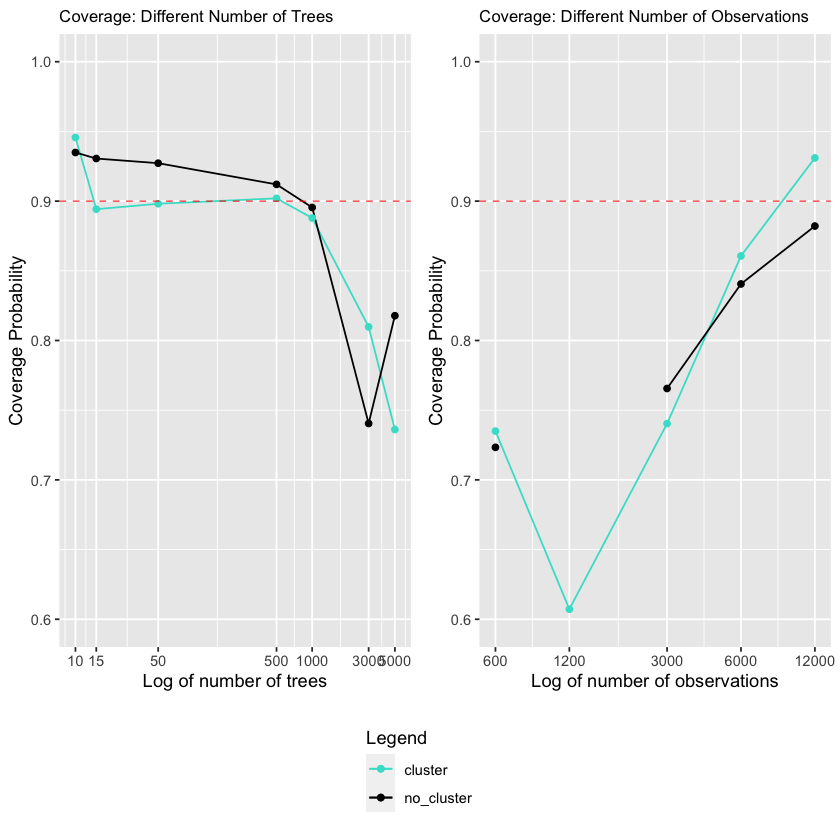

In [6]:
plot_coverage_function(n_test=9000, n_train=9000, n.trees=4000, trees=c(10, 15, 50, 500, 1000, 3000, 5000), observations=c(600, 1200, 3000, 6000, 12000))

_Note: The plots show coverage probabilites varying over the number of trees (left) and the number of training observations (right) for cluster-robust and non-cluster robust honest forests together with the target coverage of 90 percent (red dashed line). Coverage probabilities are calculated using 9000 test observations. In the left plot 9000 training observations were used. In the right plot 4000 trees were grown. The horizontal axis is displayed on log scale for both plots._

---

**Model Misspecification and the Value of Nonparametric Estimation**

Figure 2 attempts to display a typical situation a researcher mind find herself in who suspects heterogeneity in treatment effects along two dimensions, in this case the total budget of the village and the salary of the village head. She may estimate the misspecified medium complexity model including simple interactions and interactions between the treatment and the squares of the total budget and the village head salary. The true data generating process, however, might be given by the medium complexity model that, beyond the simple interactions, includes a triple interaction and an interaction between treatment and the square of village head salary. As figure 1 shows, if the researcher estimates the correctly specified model, the estimated treatment effect function $\hat{\tau}(x)_{linear, \, true}$ provides a better fit to the true treatment effect function $\tau(x)$ than the honest causal forest does. In particular, the increase in the treatment effect for large salaries and large budgets is more accurately captured in the correctly specified linear model. The estimated treatment effect function using the causal forest $\hat{\tau}(x)_{honest \, CF}$ performs better than the misspecified linear model in characterizing the true treatment effect function. This illustrates one advantage of using causal forests over estimating parametric models: the causal forest does not impose specific functional forms and the researcher can thus hope to obtain fairly accurate estimates of conditional average treatment effects even without knowing the true data generating process.

---

**Figure 2: The Value of Nonparametric Estimation**

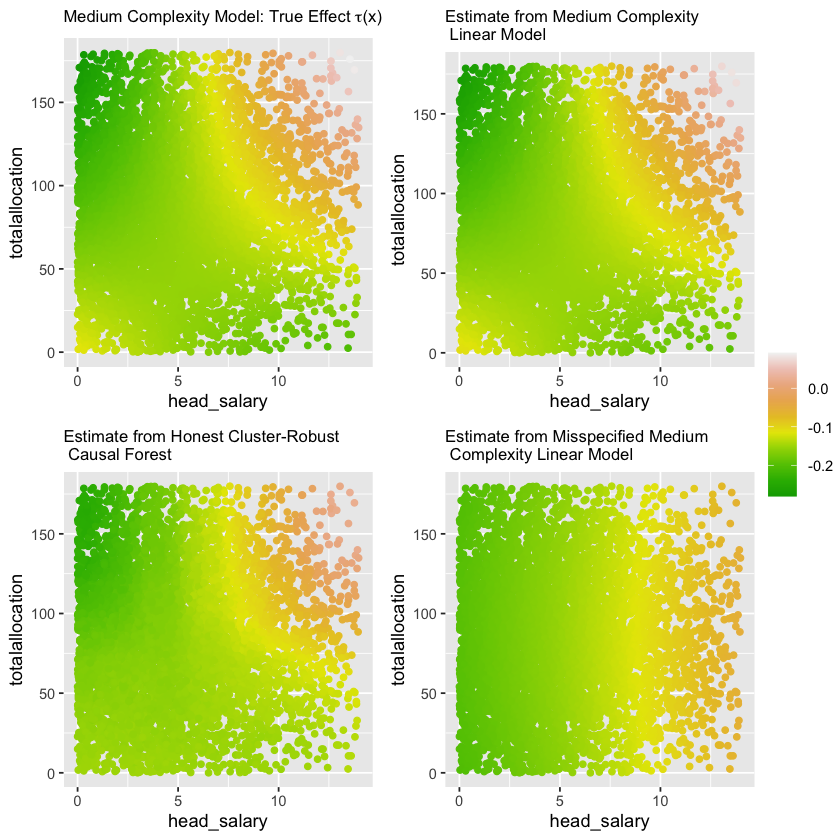

In [7]:
figure2(n_test=6000, n_train=6000, n.trees=2000, model='medium', N_clusters=150)

_Note: The plots show the true treatment effect $\tau(X_i)$ (upper left), the medium complexity linear model estimate $\hat{\tau}(X_i)_{linear,\, true}$ (upper right), the honest causal forest estimate $\hat{\tau}(X_i)_{honest \, CF}$ (lower left) and the misspecified medium complexity linear model estimate $\hat{\tau}(X_i)_{linear,\, misspecified}$ (lower left) for 5679 test observations $X_i$. The test observations were restricted to have head_salary less than 14 and totalallocation less than 180. This removes outliers and allows to visualize the granularity of the difference in the treatment effect functions._

---

## 5. Empirical Application

In this section, the causal forest algorithm is applied to the empirical data used by Olken (2007). 

In [8]:
ATE_function(randomization_data, road_data)

ERROR: Error in causal_forest(X = X, Y = merged_data$ln_diff_items, W = merged_data$audit, : Objekt 'mtry' nicht gefunden


CATE_plot_function<-function(dataset1, dataset2){
    empirical_results<-cf_empirical_function(dataset1, dataset2)

tauhat_df<-data.frame()
p<-list()

for (i in c('tauhat_honest_clustered', 'tauhat_honest_not_clustered', 'tauhat_adaptive')){


tauhat<-as.data.frame(empirical_results[i])
#tauhat_df<-cbind(tauhat_df, tauhat)
p[[i]]<-ggplot(tauhat, aes_string(x=tauhat[,i])) + 
    geom_histogram()
}


do.call(grid.arrange, p)
}

CATE_plot_function(randomization_data, road_data)

---

**Figure 3: Conditional Average Treatment Effects**

In [ ]:
boxplots(forest='cf_honest_clustered', variable_importance='variable_importance_honest_clustered')

_Note: Plots show CATE boxplots for selected variables with high variable importance as selected by the causal forest algorithm._

---

## References

**Abadie, A., Athey, S., Imbens, G.W. and Wooldridge, J. (2017).** When Should You Adjust Standard Errors for Clustering? National Bureau of Economic Research,  Working Paper No. 24003.

**Athey, S. (2018).** Machine learning for heterogeneous treatment effects and personalized policy
estimation. University of California, Davis. The University of California Lecture.

**Athey, S. and Imbens, G. (2016).** Recursive partitioning for Heterogeneous Causal Effects. Proceedings of the National Academy of Sciences 113, 7353–7360.

**Athey, S. Tibshirani, J. and Wager, S. (2019).** Generalized Random Forests. Annals of Statistics 47 (2), 1148-1178.

**Athey, S. and Wager, S. (2019).** Estimating Treatment Effects with Causal Forests: An Application. arXiv preprint arXiv:1902.07409.

**Breiman, L. (2001).** Random forests. Machine Learning 45 (1), 5–32 (2001)

**Davis, J.M.V., and Heller, S.B. (2017).** Using Causal Forests to Predict Treatment Heterogeneity: An Application to Summer Jobs. American Economic Review 107 (5), 546-50.

**Wager, S. and Athey, S. (2018).** Estimation and Inference of Heterogeneous Treatment Effects using Random Forests. Journal of the American Statistical Association 113(523), 1228-1242.